In [43]:
import os
import random
import requests
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pickle


# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats 

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Define the file paths
path1 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'
path2 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    new_df = pd.read_csv(path1) 
elif os.path.exists(path2):
    new_df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [3]:
new_df.head(2)

,time,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label,Complaint_Count_diff1
0,2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1,NaN
1,2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1,2.0


In [4]:
df = new_df.drop(columns=['relative_humidity_2m_mean','weather_label', 'Complaint_Count_diff1'])

In [5]:
df.set_index('time', inplace=True)

In [6]:
df.head(2)

,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year
time,,,,,,,
2022-06-10,41.0,0.1,4,6,16.6,10,2022
2022-06-11,41.0,0.2,5,6,25.3,12,2022


In [7]:
# Separate features (X) and target (y)
X = df.drop(columns=['Complaint_Count'])
y = df['Complaint_Count']
# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]
# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Date range - Train: {df.index[0]} to {df.index[train_size-1]}")
print(f"Date range - Test: {df.index[train_size]} to {df.index[-1]}")

X_train shape: (946, 6)
X_test shape: (237, 6)
y_train shape: (946,)
y_test shape: (237,)
Training set size: 946
Test set size: 237
Date range - Train: 2022-06-10 to 2025-01-30
Date range - Test: 2025-01-31 to 2025-10-19


In [8]:
'''
#### MODEL TRAINING

# Define ranges for parameters
p = d = q = range(0, 3)  # Non-seasonal parameters
P = D = Q = range(0, 3)  # Seasonal parameters
s = [7]  # Seasonal period (e.g. 24 for hourly data)

# Create all combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

results_list = []

for params in param_combinations:
    try:
        # Unpack parameters
        p, d, q, P, D, Q, s = params
        
        model = SARIMAX(
            endog=y_train,
            exog=X_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False)
        
        results_list.append({
            'order': (p, d, q),
            'seasonal_order': (P, D, Q, s),
            'AIC': results.aic,
            'BIC': results.bic
        })
    except:
        continue

# Convert to DataFrame
tuning_results = pd.DataFrame(results_list)

'''

"\n#### MODEL TRAINING\n\n# Define ranges for parameters\np = d = q = range(0, 3)  # Non-seasonal parameters\nP = D = Q = range(0, 3)  # Seasonal parameters\ns = [7]  # Seasonal period (e.g. 24 for hourly data)\n\n# Create all combinations\nparam_combinations = list(itertools.product(p, d, q, P, D, Q, s))\n\nresults_list = []\n\nfor params in param_combinations:\n    try:\n        # Unpack parameters\n        p, d, q, P, D, Q, s = params\n        \n        model = SARIMAX(\n            endog=y_train,\n            exog=X_train,\n            order=(p, d, q),\n            seasonal_order=(P, D, Q, s),\n            enforce_stationarity=False,\n            enforce_invertibility=False\n        )\n        \n        results = model.fit(disp=False)\n        \n        results_list.append({\n            'order': (p, d, q),\n            'seasonal_order': (P, D, Q, s),\n            'AIC': results.aic,\n            'BIC': results.bic\n        })\n    except:\n        continue\n\n# Convert to DataFram

In [10]:
# Sort by AIC
#best_model = tuning_results.sort_values('AIC').iloc[0]
#print("Best SARIMAX Parameters:")
#print(f"Order: {best_model['order']}")
#print(f"Seasonal Order: {best_model['seasonal_order']}")
#print(f"AIC: {best_model['AIC']}")

In [13]:
# best_model parm


#order    =            (0, 1, 2)
#seasonal_order  =  (1, 1, 2, 7)
#AIC                 6750.79102
#BIC                6808.696541
# Name: 149, dtype: object

In [12]:
best_order = (0, 1, 2)
best_seasonal_order = (1, 1, 2, 7)

final_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(final_model.summary())

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                   Complaint_Count   No. Observations:                  946
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 7)   Log Likelihood               -3363.396
Date:                           Thu, 30 Oct 2025   AIC                           6750.791
Time:                                   04:18:09   BIC                           6808.697
Sample:                                        0   HQIC                          6772.887
                                           - 946                                         
Covariance Type:                             opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
temp_max_C             0.3637      0.151      2.416      0.016       0.069       0.659
precip_mm          

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
y_pred = final_model.predict(start=len(y_train),end=len(y_train) + len(y_test) - 1, exog=X_test)

# Combine results
forecast_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred.values,
}, index=y_test.index)

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
print("\nForecast Sample:")
print(forecast_df.head())


Forecast Sample:
            Actual  Predicted
time                         
2025-01-31      44  21.114028
2025-02-01      22  14.556265
2025-02-02      26  14.480015
2025-02-03      13  18.297781
2025-02-04      40  16.644300


In [16]:
# Ensure both y_test and y_pred are numpy arrays and aligned properly
y_true = np.array(y_test)
y_pred_values = np.array(y_pred)

# Core metrics
mae = mean_absolute_error(y_true, y_pred_values)
mse = mean_squared_error(y_true, y_pred_values)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_values)

# Safe MAPE calculation (exclude zero or negative actuals)
non_zero_mask = y_true != 0
if np.any(non_zero_mask):  # Avoid division by zero
    mape = (np.abs((y_true[non_zero_mask] - y_pred_values[non_zero_mask]) / y_true[non_zero_mask]).mean()) * 100
else:
    mape = np.nan  # or handle gracefully

# Display
print("\n📊 Model Evaluation Metrics:")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")
print(f"MAPE  : {mape:.2f}%")




📊 Model Evaluation Metrics:
MAE   : 21.9496
MSE   : 743.0620
RMSE  : 27.2592
R²    : -1.1894
MAPE  : 48.77%


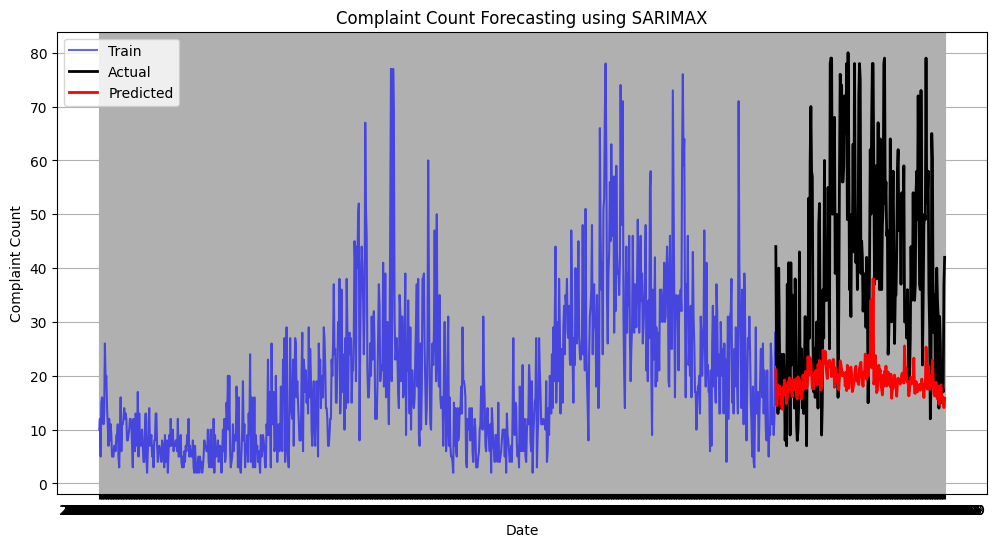

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train', color='blue', alpha=0.6)
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linewidth=2)
plt.title("Complaint Count Forecasting using SARIMAX")
plt.xlabel("Date")
plt.ylabel("Complaint Count")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# SARIMAX Model Performance Visualization

# Ensure datetime index
y_test.index = pd.to_datetime(y_test.index)
y_pred.index = pd.to_datetime(y_pred.index)

y_true = np.array(y_test)
y_pred_values = np.array(y_pred)

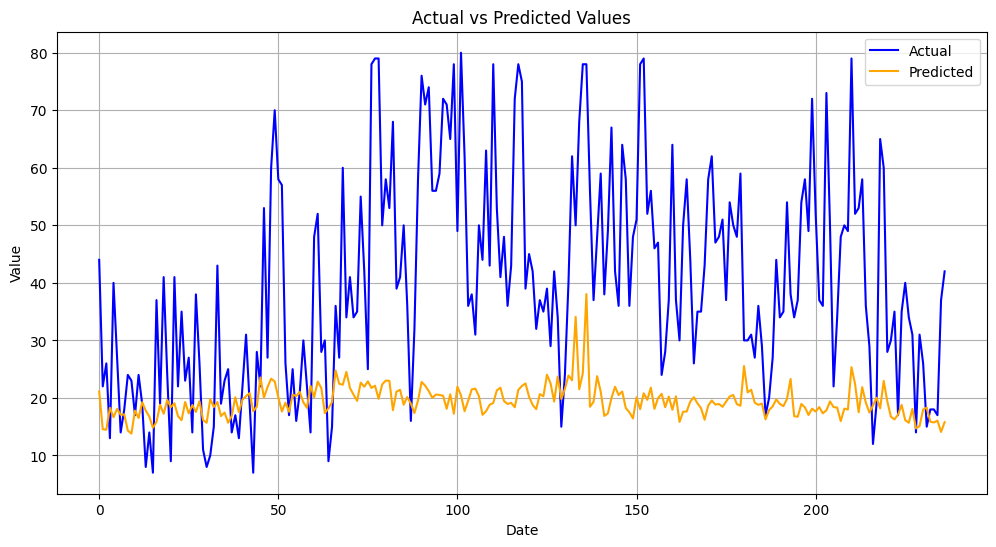

In [22]:
# 1️⃣ Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred_values, label='Predicted', color='orange')
plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

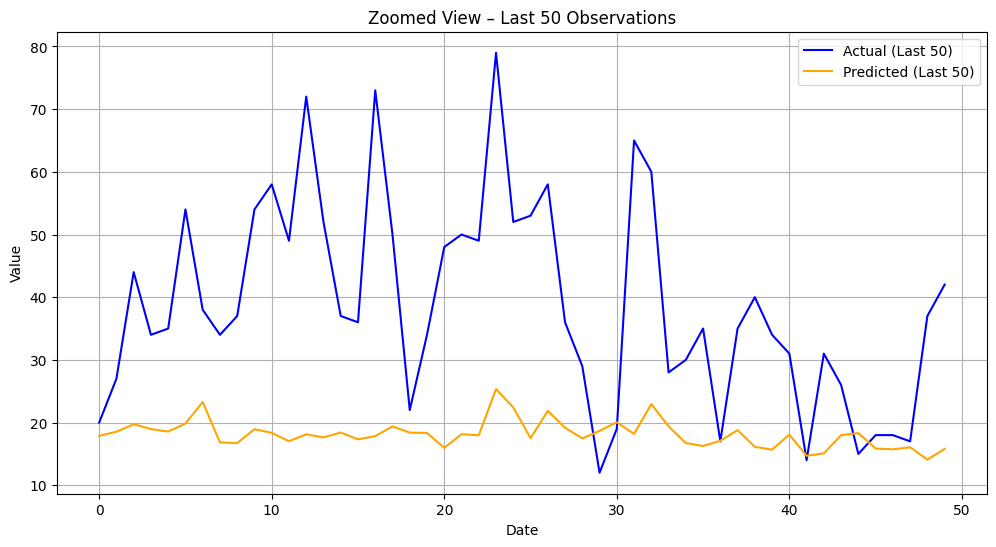

In [23]:
# 2️⃣ Zoomed-in Comparison (Last 50 points)
plt.figure(figsize=(12,6))
plt.plot(y_true[-50:], label='Actual (Last 50)', color='blue')
plt.plot(y_pred_values[-50:], label='Predicted (Last 50)', color='orange')
plt.title("Zoomed View – Last 50 Observations")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

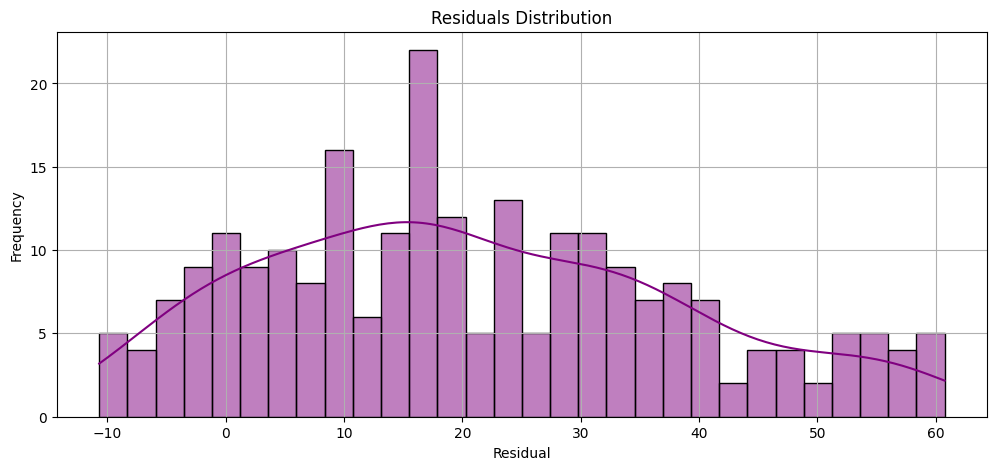

In [24]:
# 3️⃣ Residual Analysis
residuals = y_true - y_pred_values

plt.figure(figsize=(12,5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

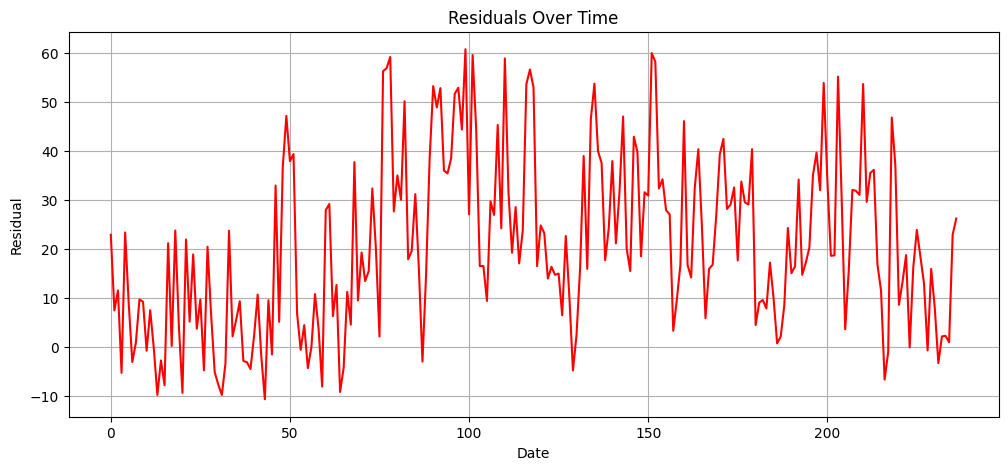

In [25]:
# 4️⃣ Residuals over time
plt.figure(figsize=(12,5))
plt.plot(residuals, color='red')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.show()


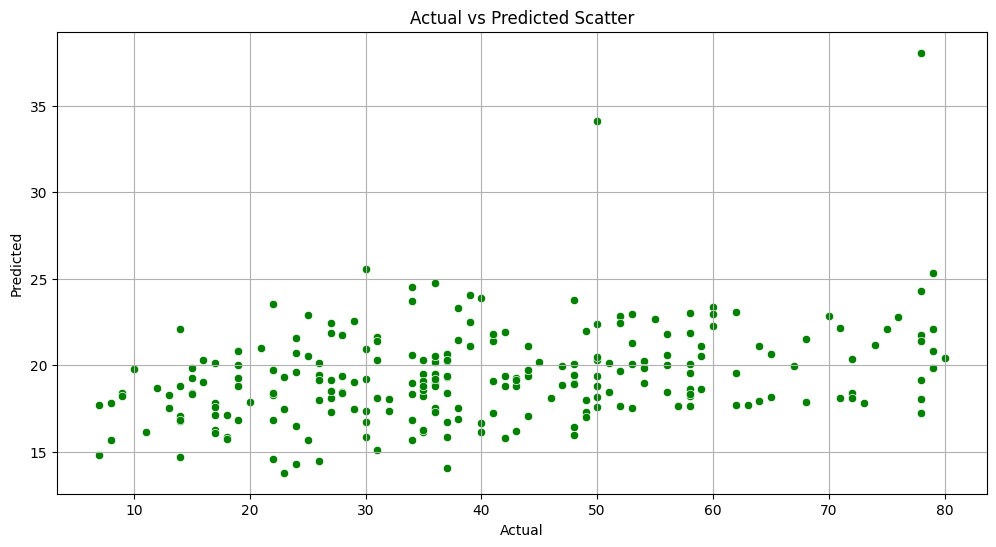

In [26]:
# 5️⃣ Actual vs Predicted Scatter Plot
plt.figure(figsize=(12,6))
sns.scatterplot(x=y_true, y=y_pred_values, color='green')
plt.title("Actual vs Predicted Scatter")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

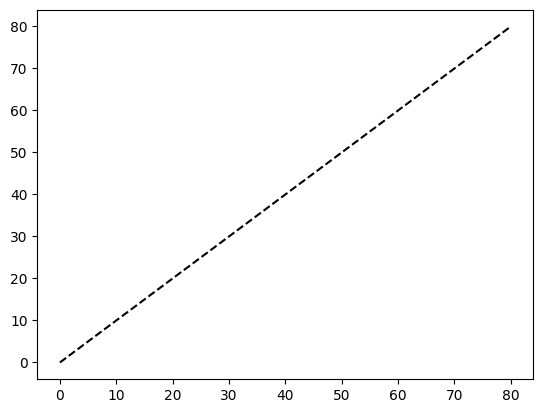

In [27]:
# Diagonal reference line
max_val = max(y_true.max(), y_pred_values.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
plt.show()

In [30]:
# Next 30 Days Forecast 

# 🔹 Number of steps to forecast
n_steps = 30

# 🔹 Prepare future exogenous variables (X_future) if applicable
# If you have future features, use them. Otherwise, pass None
  # or your prepared exogenous DataFrame

# APPROACH 3: Use recent average (last 30 days)
X_future_recent = pd.DataFrame(
    np.tile(X.iloc[-30:].mean().values, (30, 1)),
    columns=X.columns
)
# 🔹 Generate forecast
forecast_obj = final_model.get_forecast(steps=n_steps, exog=X_future_recent)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()


# 🔹 Create future date index based on your dataset frequency
last_date = y.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_steps + 1, freq='D')[1:]  # daily frequency
forecast_mean.index = future_dates
forecast_ci.index = future_dates


c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
#import pickle
# Save model
#with open("sarimax_model.pkl", "wb") as f:
#pickle.dump(final_model, f)